In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp.tables import tbls
from calitp import query_sql
import calitp.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
from rt_analysis import rt_filter_map_plot

from IPython.display import display, Markdown, Latex, HTML
import json

In [105]:
## parameters cell
itp_id = 98

In [106]:
if itp_id == 273:
    analysis_date = dt.date(2022, 2, 8) ## override for SacRT
elif itp_id == 351:
    analysis_date = dt.date(2022, 11, 2) ## override for Unitrans
else:
    analysis_date = dt.date(2022, 10, 12) #rebuild site

In [107]:
%%capture_parameters
human_date = analysis_date.strftime('%B %d (%A)')
human_date

{"human_date": "October 12 (Wednesday)"}


In [108]:
%%capture
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

In [109]:
%%capture_parameters
agency_name = rt_day.calitp_agency_name
if itp_id == 148:
    agency_name = 'Kings Area Regional Transit' ## rename pending warehouse rewrite
agency_name

{"agency_name": "Dumbarton Express"}


# {agency_name}

## About These Maps:

* Each map shows bus (and rail, if applicable) speeds for {agency_name}, with a map each for the morning peak, midday, and afternoon peak periods on {human_date}.
* On the map, routes are split into segments corresponding to the distance between two stops, allowing you to focus on specific portions of the route experiencing a slowdown.
* Route segments are arrow-shaped to indicate direction of travel. Thicker segments indicate more frequent transit routes.
* Hover over, or click, a segment with your mouse to see the exact speed, route name, and transit service frequency in that segment. 
    * Higher-frequency routes (3+ trips per hour) are especially important, since those slowdowns correspond to more vehicles, and riders, delayed in traffic.

## Morning Peak

In [110]:
%%capture
rt_day.set_filter(start_time='06:00', end_time='09:00')

In [111]:
## avoid papermill errors when map fails to render
m = None

In [112]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [113]:
m

In [114]:
rt_day.describe_slow_routes()

AM Peak slowest routes: 
 * DB, Dumbarton Exp. - Palo Alto, Southbound: 17.6 mph median trip speed for 1 trip
 * DB1, Dumbarton Exp. - Research Park, Northbound: 19.8 mph median trip speed for 5 trips
 * DB1, Dumbarton Exp. - Research Park, Southbound: 22.3 mph median trip speed for 5 trips
 * DB, Dumbarton Exp. - Palo Alto, Northbound: 26.9 mph median trip speed for 2 trips

## Midday

In [115]:
%%capture
rt_day.set_filter(start_time='10:00', end_time='14:00')

In [116]:
## avoid papermill errors when map fails to render
m = None

In [117]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [118]:
m

In [119]:
rt_day.describe_slow_routes()

Midday slowest routes: 
 * DB, Dumbarton Exp. - Palo Alto, Northbound: 15.1 mph median trip speed for 2 trips
 * DB, Dumbarton Exp. - Palo Alto, Southbound: 15.7 mph median trip speed for 2 trips
 * DB1, Dumbarton Exp. - Research Park, Northbound: 21.3 mph median trip speed for 3 trips
 * DB1, Dumbarton Exp. - Research Park, Southbound: 21.4 mph median trip speed for 1 trip
 * DB1, Dumbarton Exp. - Research Park, Northbound: 24.5 mph median trip speed for 1 trip
 * DB1, Dumbarton Exp. - Research Park, Southbound: 25.8 mph median trip speed for 3 trips

## Afternoon Peak

In [120]:
%%capture
rt_day.set_filter(start_time='15:00', end_time='19:00')

In [121]:
## avoid papermill errors when map fails to render
m = None

In [122]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [123]:
m

In [124]:
rt_day.describe_slow_routes()

PM Peak slowest routes: 
 * DB, Dumbarton Exp. - Palo Alto, Northbound: 11.3 mph median trip speed for 6 trips
 * DB, Dumbarton Exp. - Palo Alto, Southbound: 11.5 mph median trip speed for 6 trips
 * DB1, Dumbarton Exp. - Research Park, Northbound: 16.8 mph median trip speed for 4 trips
 * DB1, Dumbarton Exp. - Research Park, Southbound: 19.4 mph median trip speed for 3 trips

In [125]:
try:
    metrics_df = (rt_day.rt_trips
         >> group_by(_.route_short_name, _.direction_id)
         >> summarize(speed_variance = _.mean_speed_mph.var(),
                     mean_speed_mph = _.mean_speed_mph.mean(),
                     min_hour = _.median_time.min().hour,
                     max_hour = _.median_time.max().hour,
                     n = _.route_short_name.size)
         >> filter(_.min_hour <= 7, _.max_hour >= 15,
                   _.mean_speed_mph < _.mean_speed_mph.quantile(.6),
                   _.speed_variance, _.n > _.n.quantile(.4))
         >> arrange(-_.speed_variance)
         >> head(20)
        )
except Exception as e:
    pass
    # print(e)
## check that route has all-day span...

In [126]:
def map_from_metrics(rt_day, metrics_df):
    def show_title_and_map():
        try:
            am_map = rt_day.segment_speed_map(how='low_speeds', no_title = True)
            display(Markdown(f'20th Percentile Vehicle Speeds Between Stops{rt_day.filter_formatted}'))
            display(am_map)
        except Exception as e:
            display(Markdown(f'Map not available for this time/route'))
            pass
        return
    try:
        route_name = metrics_df.iloc[1,0]
        direction_id = metrics_df.iloc[1,1]
        # print(route_name, direction_id)
    except Exception as e:
        # print(e)
        return
    rt_day.set_filter(start_time='06:00', end_time='09:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()
    
    rt_day.set_filter(start_time='10:00', end_time='14:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    rt_day.set_filter(start_time='15:00', end_time='19:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    return

## Daily Speed Patterns

* This chart shows the distribution of median trip speeds throughout the day. It can help find times of day where transit riders experience the slowest overall speeds.

Median Trip Speed by Hour of Day, All Route Types, All Routes, 06:00–22:00, Oct 12 (Wed)

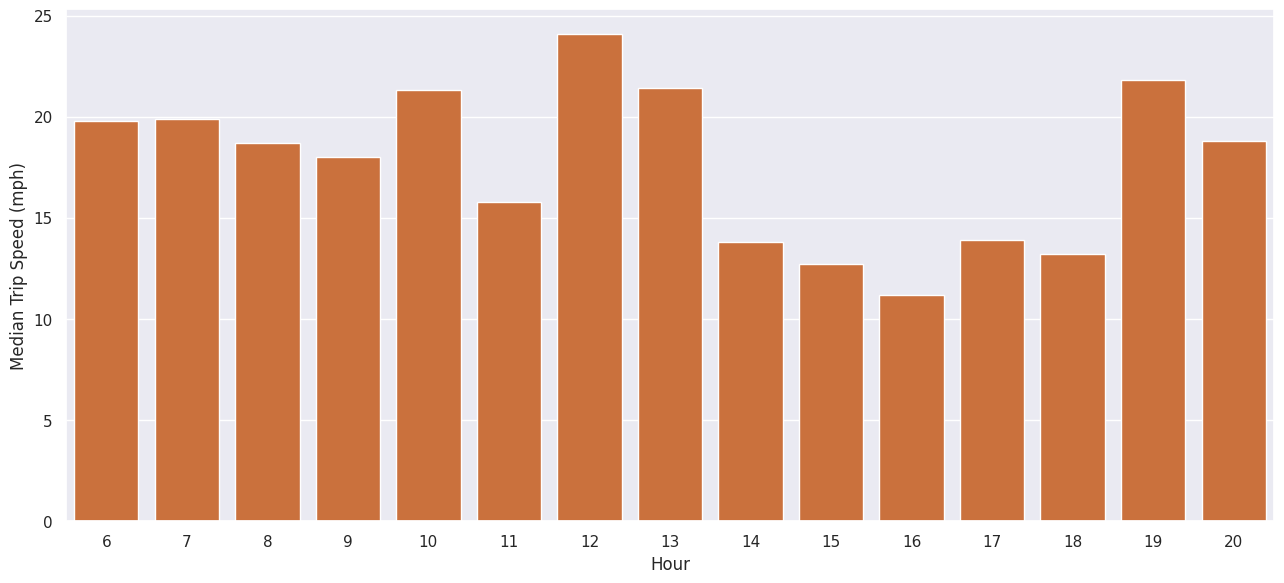

In [127]:
try:
    rt_day.set_filter(start_time='06:00', end_time='22:00')
    display(Markdown(f'Median Trip Speed by Hour of Day{rt_day.filter_formatted}'))

    rt_day.chart_speeds(no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass

## Single-Route Detail Example

* These maps highlight a single route which runs throughout the day, with a low average trip speed and a high amount of variation in speeds between different trips.

In [128]:
try:
    map_from_metrics(rt_day, metrics_df)
except Exception as e:
    # print(e)
    pass

## Single Route Speed Variability

* This chart shows the _variability_ in speeds experienced by afternoon peak trips on the route mapped above. In this chart, each vertical strip corresponds to a segment of the map above. Within each strip, each dot represents the speed experienced in that segment by each trip in the afternoon peak. The segments are labelled by their end stop, generally a cross-street. Segments with high variability (some fast trips and some slow trips) might be better-suited to a different set of projects than segments that experience consistently slow speeds.

Speed Variablity by Stop Segment, All Route Types, All Routes, 06:00–22:00, Oct 12 (Wed)

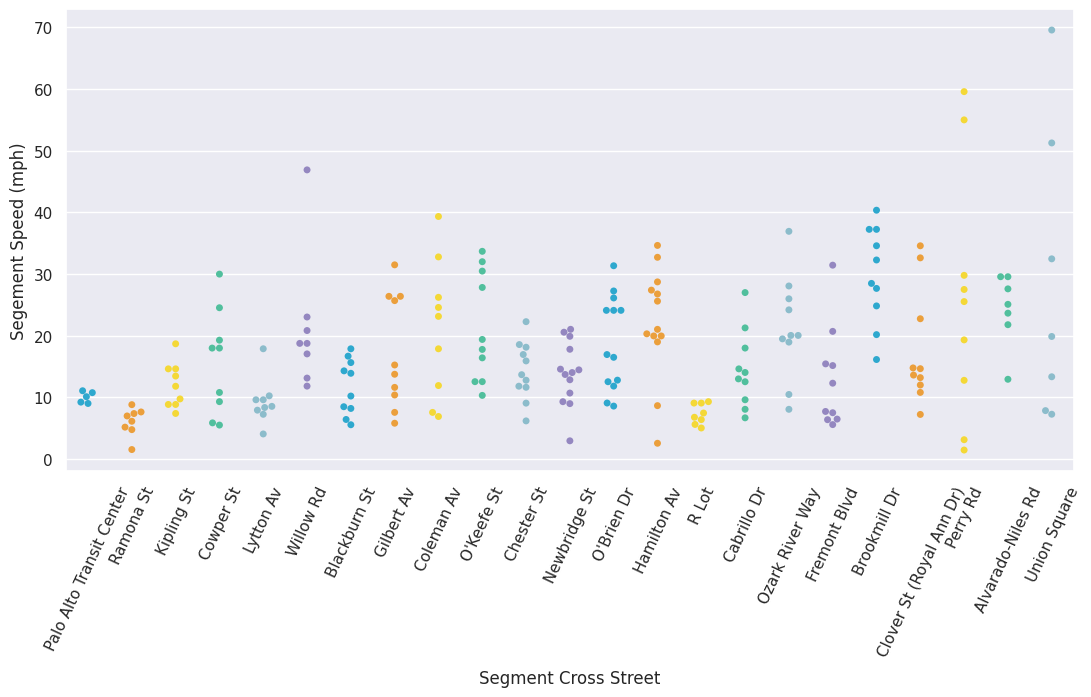

In [129]:
try:
    rt_day.filter['shape_ids'] = [(rt_day._filter(rt_day.rt_trips) >> count(_.shape_id)).shape_id.iloc[0]]

    display(Markdown(f'Speed Variablity by Stop Segment{rt_day.filter_formatted}'))

    ## filter to a max number of segments to display, split out title
    rt_day.chart_variability(num_segments=30, no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass